<a href="https://colab.research.google.com/github/saguileran/MD-SCPI/blob/main/NoteBooks/PlotEnergies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install packaages

In [1]:
%%capture
import sys
# install jscatter as user in the current Jupyter kernel
!{sys.executable} -m pip install jscatter
!{sys.executable} -m pip install ipympl

# Import libraries

In [15]:
%matplotlib ipympl

import jscatter as js
import matplotlib.pyplot as plt
import os 
import numpy as np
from google.colab import output
import pandas as pd
import seaborn as sb 
import matplotlib.gridspec as gridspec


js.usempl(True)  # use matplotlib
#js.usempl(False) # default, use grace on your computer with xmgrace in external window.


output.enable_custom_widget_manager()

Using  mpl


# Import Files

In [3]:
#@title Import files from google
#from google.colab import drive

#drive.flush_and_unmount()
#drive.mount('/content/drive', force_remount=False)

In [4]:
#@title Github

!rm -r /content/MD-SCPI
!git clone https://github.com/saguileran/MD-SCPI


Cloning into 'MD-SCPI'...
remote: Enumerating objects: 631, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 631 (delta 70), reused 69 (delta 43), pack-reused 497
Receiving objects: 100% (631/631), 172.72 MiB | 15.02 MiB/s, done.
Resolving deltas: 100% (300/300), done.
Updating files: 100% (153/153), done.


In [47]:
work_directory_AS4 = '/content/MD-SCPI/PDBs/MD/AS4' #'/content/drive/MyDrive/MolecularDynamics_2023/USP/AS4/Energies'
work_directory_COL = '/content/MD-SCPI/PDBs/MD/COL' #'/content/drive/MyDrive/MolecularDynamics_2023/USP/COL/Energies'

files = os.listdir(work_directory_AS4)
ligand_files = np.array([file for file in files if 'ligand' in file])
[print(i, ligand_files[i]) for i in range(ligand_files.size)];
ligand_files_interesting = ligand_files[[1,6,7,9]]

dt = 0.002*1e3 # ste time in ns

0 ligand-HH22.dat
1 ligand-protein.dat
2 ligand-solvent.dat
3 ligand-THR220.dat
4 ligand-SER85.dat
5 ligand-GLN51.dat
6 ligand-env.dat
7 ligand-ASN45.dat
8 ligand-SER118.dat
9 ligand-ARG92.dat


In [130]:
ligand_files_interesting

array(['ligand-protein.dat', 'ligand-env.dat', 'ligand-ASN45.dat',
       'ligand-ARG92.dat'], dtype='<U18')

In [129]:
'''
plt.close()
energies = pd.DataFrame()

for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
  energy = pd.DataFrame({'time':data.X/dt, 'energy':data.Y + data.eY, 'with':[file[7:-4]]*data.Y.size})
  energies = energies.append(energy, ignore_index=True)

g = sb.jointplot(data=energies, x="time", y="energy", hue="with", xlim=(-2,502), height=10, ratio=4) #marginal_kws=dict(bins=30))
g.ax_marg_x.remove()
'''

'\nplt.close()\nenergies = pd.DataFrame()\n\nfor file in ligand_files_interesting:\n  data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore=\'#\'\n  energy = pd.DataFrame({\'time\':data.X/dt, \'energy\':data.Y + data.eY, \'with\':[file[7:-4]]*data.Y.size})\n  energies = energies.append(energy, ignore_index=True)\n\ng = sb.jointplot(data=energies, x="time", y="energy", hue="with", xlim=(-2,502), height=10, ratio=4) #marginal_kws=dict(bins=30))\ng.ax_marg_x.remove()\n'

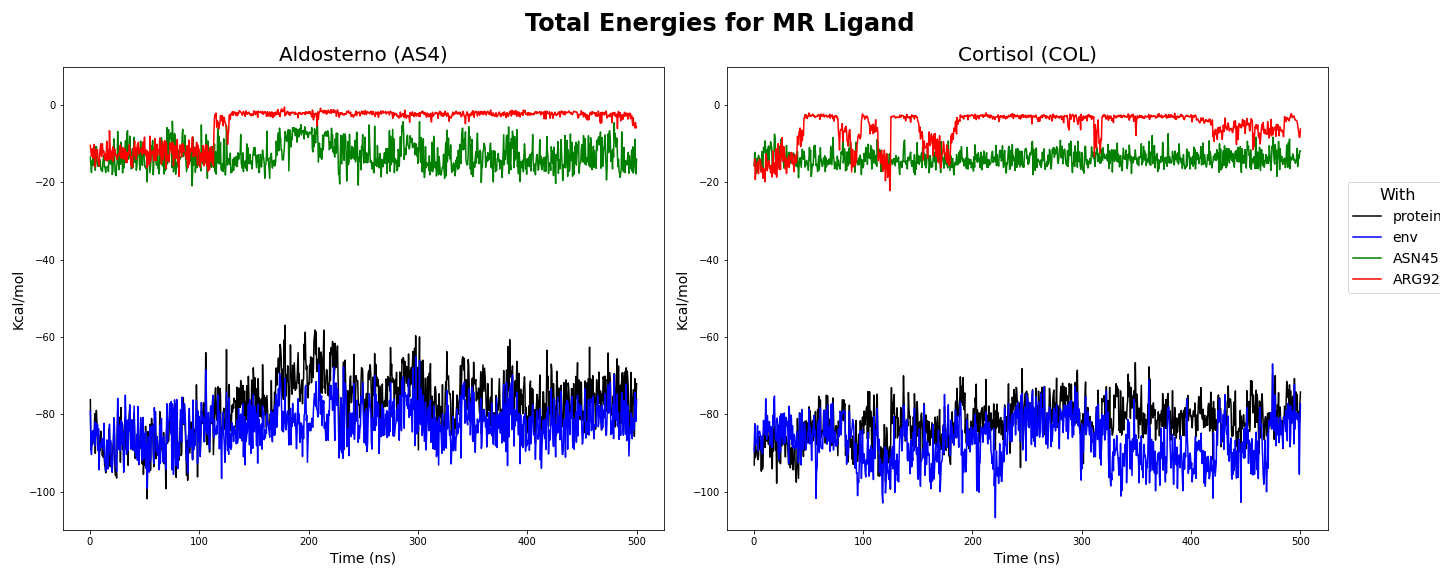

In [132]:
colors = ['black', 'blue', 'green', 'red']

plt.close()
fig, axs = plt.subplots(1,2,figsize=(20,8))

# -------------- aldosterone -------------------------
c = 0
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
  axs[0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
  c+=1

axs[0].set_xlabel('Time (ns)', fontsize='14')
axs[0].set_ylabel('Kcal/mol', fontsize='14')
axs[0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
axs[0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

# ------------------ cortisol --------------------------
c=0
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
  axs[1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4], color=colors[c])
  c+=1

axs[1].set_xlabel('Time (ns)', fontsize='14')
axs[1].set_ylabel('Kcal/mol', fontsize='14')
legend = axs[1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
axs[1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
#axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

axs[1].sharey(axs[0]); axs[1].sharex(axs[0]) # share x and y axis

#plt.rcParams['legend.title_fontweight'] = 'bold'

# axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
fig.tight_layout()
plt.show()

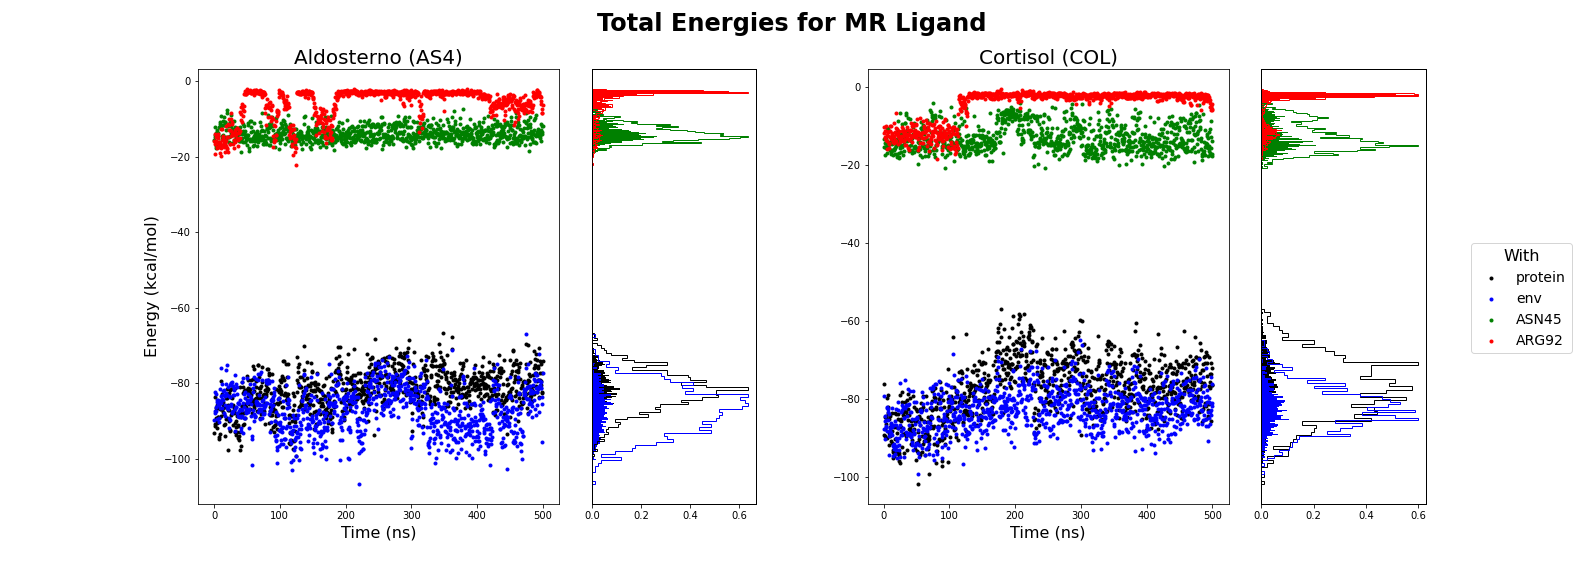

In [163]:
plt.close()

fig = plt.figure(figsize=(22,8))

gs0 = gridspec.GridSpec(1, 2, figure=fig)
gs00 = gridspec.GridSpecFromSubplotSpec(1, 3, subplot_spec=gs0[0])

#gs = gridspec.GridSpec(1, 3)

# -------- cortisol --------------
ax_main = plt.subplot(gs00[0:2, :2])
ax_yDist = plt.subplot(gs00[:1, 2],sharey=ax_main)

c=0
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_COL, file)) 
  x, y = data.X/dt, data.Y + data.eY
  ax_main.scatter(x,y,marker='.', label=file[7:-4], color=colors[c])

  ax_yDist.hist(y,bins=100,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=50,cumulative=False,histtype='step',density=True,color=colors[c],align='mid',orientation='horizontal')
  
  ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
  ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
  
  c+=1

ax_main.set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
ax_main.set_xlabel("Time (ns)", fontsize='16')
ax_main.set_ylabel("Energy (kcal/mol)", fontsize='16')
#ax_main.legend(bbox_to_anchor=(1.75, .5), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.)

#ax_yDist.set(xlabel='count')

#ax_yCumDist.tick_params('x', colors='r')
#ax_yCumDist.set_xlabel('cumulative',color='r')


#####################
# ------------ aldosterone --------------
#gs = gridspec.GridSpec(1, 3)
gs01 = gs0[1].subgridspec(1, 3)

ax_main = plt.subplot(gs01[0:2, :2])
ax_yDist = plt.subplot(gs01[:1, 2],sharey=ax_main)

c=0
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_AS4, file)) 
  x, y = data.X/dt, data.Y + data.eY
  ax_main.scatter(x,y,marker='.', label=file[7:-4], color=colors[c])

  ax_yDist.hist(y,bins=100,orientation='horizontal', align='mid', label=file[7:-4], stacked=False, density=True, color=colors[c])
  ax_yCumDist = ax_yDist.twiny()
  ax_yCumDist.hist(y,bins=50,cumulative=False,histtype='step',density=True,color=colors[c],align='mid',orientation='horizontal')
  
  ax_yCumDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
  ax_yDist.tick_params(top=False, labeltop=False, left=False, labelleft=False)
  
  c+=1

ax_main.set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
ax_main.set_xlabel("Time (ns)", fontsize='16')
#ax_main.set_ylabel("Total Energy (kcal/mol)", fontsize='16')

ax_main.legend(bbox_to_anchor=(1.95, .6), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.)

plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
plt.show()
#fig.tight_layout()


In [141]:
gs[0:2, :2]

GridSpec(1, 3)[0:1, 0:2]

In [64]:
import seaborn as sb 

penguins = sb.load_dataset("penguins")
penguins

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
3,Adelie,Torgersen,NaN,NaN,NaN,NaN,NaN
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
...,...,...,...,...,...,...,...
339,Gentoo,Biscoe,NaN,NaN,NaN,NaN,NaN
340,Gentoo,Biscoe,46.8,14.3,215.0,4850.0,Female
341,Gentoo,Biscoe,50.4,15.7,222.0,5750.0,Male
342,Gentoo,Biscoe,45.2,14.8,212.0,5200.0,Female


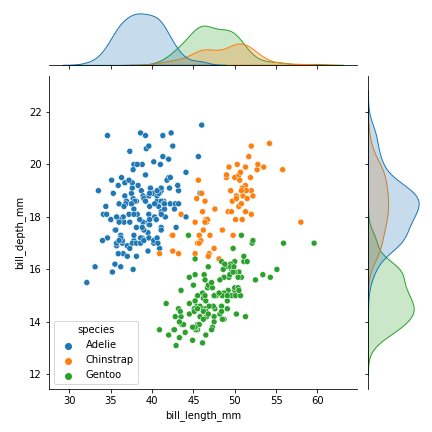

In [83]:
sb.jointplot(data=penguins, x="bill_length_mm", y="bill_depth_mm", hue="species")

In [ ]:
plt.close()
fig, axs = plt.subplots(2,2,figsize=(18,14))

# -------------- aldosterone -------------------------
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_AS4, file)) # , ignore='#'
  axs[0,0].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

#axs[0,0].set_xlabel('Time (ns)', fontsize='14')
axs[0,0].set_ylabel('Kcal/mol', fontsize='14')
axs[0,0].set_title('Aldosterno (AS4)', fontweight='normal', fontsize='20')
axs[0,0].set_ylim((-110, 10)); #axs[0].set_xlim((-0.02, 502))

# ------------------ cortisol --------------------------
for file in ligand_files_interesting:
  data=js.dA(os.path.join(work_directory_COL, file)) # , ignore='#'
  axs[0,1].plot(data.X/dt, data.Y + data.eY, label=file[7:-4])

#axs[0,1].set_xlabel('Time (ns)', fontsize='14')
#axs[0,1].set_ylabel('Kcal/mol', fontsize='14')
legend = axs[0,1].legend(bbox_to_anchor=(1.2, .75), title='With', fontsize='14', title_fontsize='16', borderaxespad=0.) 
axs[0,1].set_title('Cortisol (COL)', fontweight='normal', fontsize='20')
#axs[1].set_ylim((-110, 10)); axs[1].set_xlim((-5, 1005))

axs[0,1].sharey(axs[0,0]); axs[0,1].sharex(axs[0,0]) # share x and y axis
axs[1,0].sharey(axs[0,0]); axs[1,0].sharex(axs[0,0])
axs[1,1].sharey(axs[0,0]); axs[1,1].sharex(axs[0,0])

#plt.rcParams['legend.title_fontweight'] = 'bold'


axs[1,0].set_xlabel('Time (ns)', fontsize='14')
axs[1,1].set_xlabel('Time (ns)', fontsize='14')
axs[1,0].set_ylabel('Kcal/mol', fontsize='14')

# axs[1].legend(loc="lower left", ncol=len(ligand_files_interesting), bbox_to_anchor=(0, .0))#bbox_to_anchor=(1.25, .75), title='Residue', fontsize='14', title_fontsize='16')#, borderaxespad=0.) # 
plt.suptitle('Total Energies for MR Ligand', fontweight='bold', fontsize='24')
fig.tight_layout()
plt.show()

In [48]:
interaction = 'ligand-ASN45.dat'

def PlotAllEnergies(interaction):
  data=js.dA(os.path.join(work_directory_AS4, interaction), ignore='#')

  fig = plt.figure(figsize=(11,6))
  plt.plot(data.X, data.Y, label='Elec')
  plt.plot(data.X, data.eY, label="VDW")
  plt.plot(data.X, data.Y + data.eY, label='Total')
  plt.xlabel('Frame'); plt.ylabel('K Cal')
  plt.legend(bbox_to_anchor=(1.05, .5), title='Energy0')
  plt.title('Energies of ligand-ASN45.dat', fontweight='bold', fontsize='18')
  
  plt.show()

  return fig

In [ ]:
#help(data)

In [ ]:
#p=js.mplot()
#p.plot(data)